#Поисковая система по научной литературе для библиотеки ВИТИ МИФИ с обработкой запросов на естественном языке

##Сбор данных

Install `opendatasets` to download the dataset from Kaggle.

In [1]:
!pip install -q opendatasets

Load the `kaggle.json` file with your Kaggle token into Colab.

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


Download the folder containing the dataset.

In [3]:
import opendatasets as od

url = 'https://www.kaggle.com/datasets/alexzyukov/biti-mephi-2k-books-library'
od.download(url)

Dataset URL: https://www.kaggle.com/datasets/alexzyukov/biti-mephi-2k-books-library


100%|██████████| 628k/628k [00:00<00:00, 691MB/s]

List files in the folder.

In [48]:
import os

os.listdir('./biti-mephi-2k-books-library')

['biti-mephi-2k-books-library.csv']

Example of reading a `CSV` file with `pandas`.

In [80]:
import pandas as pd

data_file = './biti-mephi-2k-books-library/biti-mephi-2k-books-library.csv'
df = pd.read_csv(data_file, sep=';')
df.head()

,Название,Автор,Год издания,Стр,Издательство,Сссылка на книгу в ЭБС,ISBN,Аннотация
0,C#. Программирование 2D и 3D векторной графики,"Тюкачев Н. А., Хлебостроев В. Г.",2022,320,"Издательство ""Лань""",https://e.lanbook.com/book/183704,978-5-8114-8988-6,Книга посвящена программированию векторной гра...
1,JavaScript. Как писать программы,Янцев В. В.,2022,200,"Издательство ""Лань""",https://e.lanbook.com/book/197547,978-5-8114-8559-8,В книге рассматриваются все этапы написания сц...
2,"Базы данных. Проектирование, программирование,...",Волк В. К.,2022,244,"Издательство ""Лань""",https://e.lanbook.com/book/193373,978-5-8114-9368-5,Базы данных — одно из направлений IT-индустрии...
3,Большие данные. Big Data,"Макшанов А. В., Журавлев А. Е., Тындыкарь Л. Н.",2022,188,"Издательство ""Лань""",https://e.lanbook.com/book/198599,978-5-8114-9690-7,В учебнике излагается содержание курса по дисц...
4,Исследование операций. Том 1. Линейное програм...,Трушков А. С.,2022,292,"Издательство ""Лань""",https://e.lanbook.com/book/187580,978-5-8114-8282-5,В данном учебнике представлены основы теории и...


In [81]:
df.shape

(2005, 8)

## Импорты

Импортируем основные библиотеки для работы с нейросетями-трансформерами.

In [82]:
!pip install -q transformers tqdm

## Предобработка данных

Подготовка текстов для модели. Проигнорируем 2% книг, у которых нет аннотаций, так как они вносят значительный шум в итоговый результат.

In [83]:
df = df[df['Аннотация'].notna()].reset_index(drop=True)

In [84]:
from tqdm.auto import tqdm

texts = []

for i, row in tqdm(df.iterrows()):
    title = row.get('Название')
    ann = row.get('Аннотация')
    texts.append(str(title) + ' ' + str(ann))

len(texts)

0it [00:00, ?it/s]

1960

Построим гистограмму распределения текстов по длине.

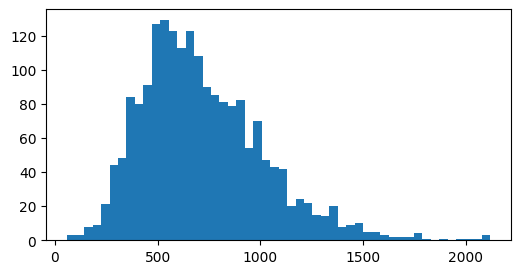

In [107]:
lens = [len(text) for text in texts]
plt.figure(figsize=(6, 3))
plt.hist(lens, bins=50)
plt.show()

#Семантический поиск с предварительной кластеризацией

##Концепция решения

Реализуем глубокий семантический поиск по книгам. Передадим тексты `названий+аннотаций` книг в нейросеть-трансформер, получим их эмбеддинги. Похожие эмбеддинги соответствуют похожим описаниям книг, а описания книгам. Сохраним эмбеддинги в файл. Произведём кластеризацию эмбеддингов, то есть сгруппируем похожие, выделим среди групп центроиды — наиболее характерные объекты. Сохраним центроиды в файл.

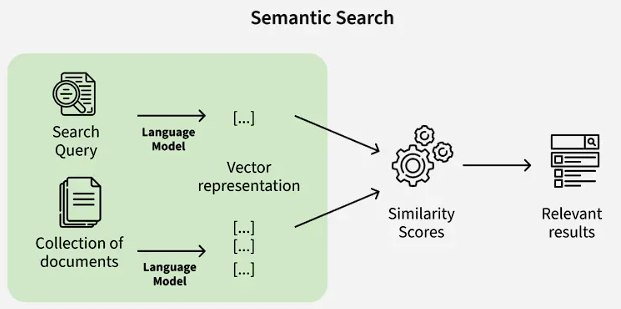

При поиске будем вычислять эмбеддинг текстового запроса пользователя, сравнивать этот эмбеддинг с ранее полученными центроидами по косинусной метрике схожести. Для наиболее похожего рассмотрим соответствующий кластер. Найдем в нем книгу с наиболее похожим на запрос пользователя эмбеддингом, будем рекомендовать её пользователю.

##Вычисление эмбеддингов

Загрузим токенизатор и модель `ruSciBERT`, дообученную на научных текстах, и вычислим эмбеддинги. Для агрегирования токенов возьмём среднее по токенам с учётом `attention_mask`.

In [109]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

MODEL_NAME = 'ai-forever/ruSciBERT'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruSciBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dr

Инициализируем классы датасета и загрузчика данных. Для ускорения работы используем `batch`.

In [110]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]


def collate_fn(batch):
    return tokenizer(
        batch,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )


dataset = TextDataset(texts)
loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

Будем обрабатывать тексты батчами.

In [111]:
import torch.nn.functional as F

all_vecs = []

with torch.no_grad():
    for enc in tqdm(loader):
        input_ids = enc['input_ids'].to(device)
        attention_mask = enc['attention_mask'].to(device)

        out = model(input_ids=input_ids, attention_mask=attention_mask)
        last = out.last_hidden_state

        mask = attention_mask.unsqueeze(-1).expand(last.size()).float()
        summed = (last * mask).sum(1)
        counts = mask.sum(1)
        vectors = summed / counts
        vectors = F.normalize(vectors, p=2, dim=1)

        all_vecs.append(vectors.cpu().numpy())

embeddings = np.vstack(all_vecs)
embeddings.shape

  0%|          | 0/245 [00:00<?, ?it/s]

(1960, 768)

Сохраним эмбеддинги и порядковые номера книг в таблице в файлы.

In [112]:
os.makedirs('data', exist_ok=True)
np.save('data/embeddings.npy', embeddings)

ids = np.arange(len(df))
np.save('data/ids.npy', ids)

df.to_csv('data/df_metadata.csv', index=False)

with open('data/embeddings.csv', 'w', encoding='utf-8') as f:
    f.write('id,embedding\n')
    for i, vec in enumerate(embeddings):
        line = str(i) + ',"' + ' '.join(map(str, vec.tolist())) + '"\n'
        f.write(line)

##Кластеризация

Для кластеризации на $K$ групп используем метод `K-Means`. Проведём подбор числа кластеров $K$ с помощью метода локтя.

In [113]:
from sklearn.cluster import KMeans

inertia = []
k_values = range(1, 11)
X = embeddings

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

График инерции.

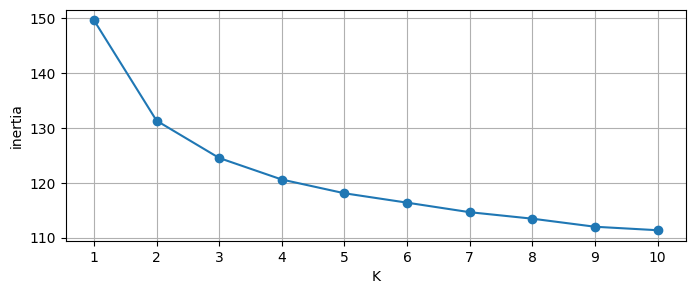

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(list(k_values), inertia, marker='o')
plt.xlabel('K')
plt.ylabel('inertia')
plt.xticks(list(k_values))
plt.grid()
plt.show()

Так как метод локтя не показал явного перегиба, соответствующего оптимальному $K$, используем метод силуэта. Будем пробовать $K$ от 2 до 20.

In [115]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


silhouette_scores = []
k_values = range(2, 21)
X = embeddings
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)
    score = silhouette_score(X, y_kmeans)
    silhouette_scores.append(score)

  0%|          | 0/19 [00:00<?, ?it/s]

Визуализируем результат.

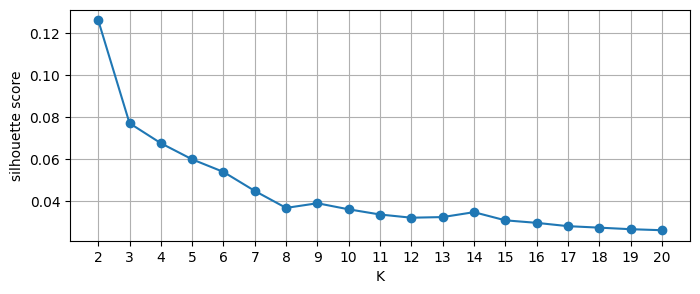

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(list(k_values), silhouette_scores, marker='o')
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.xticks(list(k_values))
plt.grid()
plt.show()

Максимум $K$ приходится на 2, это наилучшее число кластеров, на которые следует разбить все книги в датасете. График в целом показывает, что между книгами отсутствуют скрытые связи, позволяющие группировать их.

In [117]:
K = 2
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
np.save('data/labels.npy', labels)
np.save('data/centroids.npy', centers)

Визуализируем результат разбиения на кластеры, выделив 2 главных направления, вдоль которых различаются книги, через алгоритм `PCA`.

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X)
centers_pca = pca.transform(centers)

Строим график в виде облаков точек. Книги действительно разделены на 3 крупные группы и одну небольшую разреженную. То есть при таком делении в среднем на один кластер приходится около 600 объектов, именно с таким количеством эмбеддингов придётся сравнивать запрос пользователя при текущем разбиении.

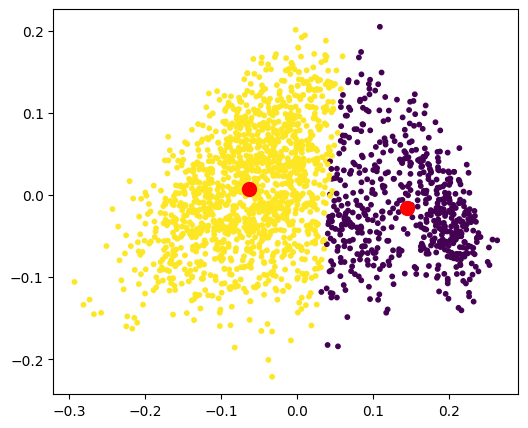

In [119]:
plt.figure(figsize=(6, 5))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, s=10)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=100, marker='o')
plt.show()
np.save('data/centroids_pca.npy', centers_pca)

Это вычислительно сложно, поэтому разобьём данные на большее число кластеров, например 10 или 20. Тогда при поиске мы сначала будем сравнивать запрос пользователя с  эмбеддингами 10 или 20 центроид, а затем с 200 или 100 эмбеддингами книг внутри кластера с лучшей центроидой.

In [120]:
K = 10
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
np.save('data/labels.npy', labels)
np.save('data/centroids.npy', centers)

Так как деление на большое число кластеров учитывает больше информации, визуальное разбиение в `2D` будет неинформативным. Построим облака точек в `3D`, это даст чуть больше информации.

In [121]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
proj = pca.fit_transform(X)
centers_pca = pca.transform(centers)

График через `plotly`. Запуск может занять время.

In [122]:
import plotly.graph_objects as go


fig = go.Figure()

# точки
fig.add_trace(
    go.Scatter3d(
        x=proj[:, 0],
        y=proj[:, 1],
        z=proj[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=labels,
            opacity=0.6
        ),
        name='Books'
    )
)

# центроиды
fig.add_trace(
    go.Scatter3d(
        x=centers_pca[:, 0],
        y=centers_pca[:, 1],
        z=centers_pca[:, 2],
        mode='markers',
        marker=dict(
            size=10,
            color='red'
        ),
        name='Centroids'
    )
)

# Удаляем оси и фон
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    width=800,
    height=650,
    margin=dict(l=0, r=0, b=0, t=20),
    showlegend=False
)

fig.show()

Данные об итоговых кластерах.

In [123]:
unique, counts = np.unique(labels, return_counts=True)
np.save('data/centroids_pca.npy', centers_pca)
dict(zip(unique, counts))

{np.int32(0): np.int64(156),
 np.int32(1): np.int64(197),
 np.int32(2): np.int64(133),
 np.int32(3): np.int64(145),
 np.int32(4): np.int64(216),
 np.int32(5): np.int64(199),
 np.int32(6): np.int64(243),
 np.int32(7): np.int64(279),
 np.int32(8): np.int64(283),
 np.int32(9): np.int64(109)}

In [124]:
df['cluster'] = labels
df.to_csv('data/df_metadata.csv', index=False)

##Результаты

Данные обработаны, результаты сохранены в файлы. Как пример пользовательского интерфейса реализован телеграм-бот, доступный в [репозитории проекта](https://github.com/pymlex).

Библиотека для использования телеграм-бота:

In [51]:
!pip install -q pytelegrambotapi

In [129]:
!python bot.py

2026-01-04 22:18:11.297245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767565091.318791   40901 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767565091.325086   40901 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767565091.341383   40901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767565091.341423   40901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767565091.341427   40901 computation_placer.cc:177] computation placer alr